# So you want to learn Julia

Julia is an open-source language focused on high-performance numerical computing (https://julialang.org). The two main components of Julia that contribute to this goal are 

- a transparent and automatic type system that can ensure *type-stability*
- a just-in-time compiler that, using the inferred types from the previous point, *compiles directly into machine code upon invocation*

Julia is in some sense a hybrid of Matlab, Python, and C++11 template types, leveraging the strengths of each approach for producing highly performant (if you know what you're doing) but readable numerical codes. Julia is still in its relative infancy (0.1 was released in 2012, it's currently on 0.6.2 with 0.7/1.0 slated for early 2018), but there have been a growing number of success stories from companies using this language in their daily operations.

Julia aims to solve the "Two Language Problem", where you have one high-level language for the bulk of your code, which calls out to a lower-level language in performance-critical regions. In this case, you'd often develop an algorithm in your high-level language of choice, to confirm the correctness of your implementation, then tediously rewrite the algorithm in a lower-level language (C, Fortran), checking against your reference implementation. The promise of Julia is that you can write high-performing and readable code once and start using it immediately. 

If you're familiar with Matlab, the Julia syntax is very similar to Matlab's syntax (probably because the founders of Julia Computing are disgruntled ex-Matlab users, as am I). 

Julia is an atypical language as most of the Julia language is written in Julia itself. This allows you to do code introspection/generation directly in Julia itself. 

In [2]:
1+1

2

In [3]:
@code_lowered 1+1

CodeInfo(:(begin 
        nothing
        return (Base.add_int)(x, y)
    end))

In [4]:
@code_warntype 1+1

Variables:
  #self# <optimized out>
  x::Int64
  y::Int64

Body:
  begin 
      return (Base.add_int)(x::Int64, y::Int64)::Int64
  end::Int64


In [5]:
@code_native 1+1

	.section	__TEXT,__text,regular,pure_instructions
Filename: int.jl
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 32
	leaq	(%rdi,%rsi), %rax
	popq	%rbp
	retq
Source line: 32
	nopw	(%rax,%rax)


In [6]:
1.0+1

2.0

In [7]:
@code_lowered 1.0+1

CodeInfo(:(begin 
        nothing
        return (Core._apply)(Base.+, (Base.promote)(x, y))
    end))

In [8]:
@code_warntype 1.0+1

Variables:
  #self# <optimized out>
  x::Float64
  y::Int64

Body:
  begin 
      return (Base.add_float)(x::Float64, (Base.sitofp)(Float64, y::Int64)::Float64)::Float64
  end::Float64


In [9]:
@code_native 1.0+1

	.section	__TEXT,__text,regular,pure_instructions
Filename: promotion.jl
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 249
	xorps	%xmm1, %xmm1
	cvtsi2sdq	%rdi, %xmm1
	addsd	%xmm1, %xmm0
	popq	%rbp
	retq
Source line: 249
	nopw	%cs:(%rax,%rax)


# Differences between Python and Julia
Python is an *interpreted*, *dynamically typed* language that has type deduction at runtime. The default, reference implementation is CPython, although other implementations such as PyPy, Jython, IronPython are available. Python compiles code to *byte code*, which is executed by the interpreter. 

Julia functions are compiled directly to machine code upon first invocation, which takes into account the types of its input arguments. 

## General
- Code blocks require an 'end' statement in Julia, tabs are irrelevant

## Arrays
- Arrays in Python/C are 0-indexed, arrays in Julia/Matlab are 1-indexed
- Array indexing in Julia is inclusive of the last element
  - e.g., a[1:3] is the array a[1], a[2], a[3]
- Julia does not support negative indexing. The last element of an array is denoted by, e.g., a[end] rather than a[-1] in Python
- Arrays are in column-major format

# Differences between Matlab and Julia
Although the syntax is quite similar, there are a number of notable differences between Matlab and Julia.

## General
- The imaginary unit is im. Complex numbers are constructed as a+b*im or Complex(a,b)
- Output arguments are assigned via tuples. There is no varargout/nargout in Julia, but a similar result can be achieved by modifying input arguments.

## Built-in types
- In Matlab, built-in numeric types are first-class objects whereas user-defined types are not as highly performant as matrices and vectors
- In Julia, there's nothing special about the built-in types -- you can write your own types that will perform just as well 

## Arrays
- Arrays are indexed by square brackets, A[i,j]
- Julia values are passed by reference, arrays are assigned by reference
- Julia doesn't automatically grow arrays 

# Julia's Type System
There are a few 

- Concrete types are final and can only subclass abstract classes
- There are no non-objects in Julia -- user-defined classes, built-in types, numeric values such as ints and floats, all are objects in the OO sense. The difference in Julia being that constructing concrete objects do not carry runtime overhead compared to say Python. 
- Values have types, variables do not (they're just names bound to variables)
- Types can be parametrized in a variety of ways, but can be omitted when there are no restrictions on them/the resulting types can be inferred by the compiler.

- Use the :: operator to specify types, A <: B denotes "A is a subtype of B"
- Objects are not bundled with the methods that operate on them, as in Python or C++. Instead, the 


In [1]:
function func(x::Float64, y::Float64)
    sin(x) + cos(y)^2
end
z = func(1,1)

LoadError: [91mMethodError: no method matching func(::Int64, ::Int64)[39m

In [2]:
z = func(1.0,1.0)

1.1333975665343254

In [3]:
function func(x::Number, y::Number)
   sin(x) + cos(y)^2 
end

func (generic function with 2 methods)

In [4]:
func(1.0+0.0im,1.0)

1.1333975665343254 + 0.0im

In [6]:
function func(x,y)
    sin(x) + cos(y)^2
end
w = func(1.0,1.0)
x = func(1,1)

LoadError: [91mMethodError: no method matching sin(::Char)[0m
Closest candidates are:
  sin([91m::BigFloat[39m) at mpfr.jl:637
  sin([91m::Complex{Float16}[39m) at math.jl:951
  sin([91m::Float16[39m) at math.jl:950
  ...[39m

In [7]:
function func(x::T,y::T) where {T}
   @show x, y
   return nothing
end
w = func('a','b')
z = func('a',1.0)

(x, y) = ('a', 'b')


LoadError: [91mMethodError: no method matching sin(::Char)[0m
Closest candidates are:
  sin([91m::BigFloat[39m) at mpfr.jl:637
  sin([91m::Complex{Float16}[39m) at math.jl:951
  sin([91m::Float16[39m) at math.jl:950
  ...[39m

In [10]:
methods(func)

# 4 methods for generic function "func":
func(x::Float64, y::Float64) in Main at In[1]:2
func(x::Number, y::Number) in Main at In[3]:2
func(x::T, y::T) where T in Main at In[7]:2
func(x, y) in Main at In[6]:2

In [11]:
function func(x::T,y::T) where {T<:AbstractString}
   return x * " " * y
end
func("a","b")

"a b"

In [12]:
methods(func)

# 5 methods for generic function "func":
func(x::Float64, y::Float64) in Main at In[1]:2
func(x::Number, y::Number) in Main at In[3]:2
func(x::T, y::T) where T<:AbstractString in Main at In[11]:2
func(x::T, y::T) where T in Main at In[7]:2
func(x, y) in Main at In[6]:2

Because of Julia's type system, we can get really fast for loops, unlike in Python

In [13]:
N = 1000000
y = zeros(N)
@time begin
    for i = 1:N
       y[i] = sin(i)
    end
end

  0.210856 seconds (4.00 M allocations: 76.282 MiB, 5.84% gc time)


In [14]:
@time begin
   z = sin(1:N)
end


  0.432645 seconds (136.77 k allocations: 14.817 MiB, 0.93% gc time)


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] sin(::UnitRange{Int64}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] include_string(::Module, ::String, ::String) at /Users/cdasilva/.julia/v0.6/Compat/src/Compat.jl:174
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/cdasilva/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/cdasilva/.julia/v0.6/Compat/src/Compat.jl:496
 [7] eventloop(::ZMQ.Socket) at /Users/cdasilva/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[14], in expression starting on line 2


1000000-element Array{Float64,1}:
  0.841471 
  0.909297 
  0.14112  
 -0.756802 
 -0.958924 
 -0.279415 
  0.656987 
  0.989358 
  0.412118 
 -0.544021 
 -0.99999  
 -0.536573 
  0.420167 
  ⋮        
  0.935194 
  0.803283 
 -0.0671632
 -0.875859 
 -0.879294 
 -0.0743103
  0.798994 
  0.937707 
  0.214296 
 -0.706138 
 -0.977352 
 -0.349994 

In [15]:
@time begin
   z = sin.(1:N)
end
N*8/1024^2


  0.062025 seconds (23.00 k allocations: 8.787 MiB)


7.62939453125

# Calling out to C
Although Julia aims to be a one-stop shop of a language, there are easy ways to call out to C. There's no compilation step required for C, just use the function ``ccall`` with the syntax

``ccall((:func_name, "library_name"),output_type, (input_types),input1,input2,...)``

In [20]:
t = ccall((:clock, "libc"), Int32, ())

13499297

In [21]:
path = ccall((:getenv, "libc"), Cstring, (Cstring,), "SHELL")
unsafe_string(path)

"/bin/bash"

# Calling out to Python/C++
There's no native functions for calling Python or C++ functions, but there are a few packages available that perform this operation:
- PyCall.jl - https://github.com/JuliaPy/PyCall.jl
- CxxWrap.jl - https://github.com/Keno/Cxx.jl/

# The Good
- Vibrant community of core language developers as well as external package developers
  - Central, open source repository of packages for solving differential equations, doing numerical linear algebra, solving optimization problems, plotting, etc.
- High performance code with relatively straightforward 
- Easy to generate code with metaprogramming

# Fun miscellany
Julia has support for unicode + some latex characters with tab-completion, so you can write valid code like

In [24]:
f = x->sin(x)
∇f = x->cos(x)
f(π), ∇f(π)

(1.2246467991473532e-16, -1.0)

# Package Management/Usage
Julia has its own pip-like package manager. The Julia package manager is very much git/github-based, with each package being hosted as its own git repository. 

In [25]:
# Update your installed packages
Pkg.update()

# Add a registered package 
Pkg.add("Revise")
Pkg.add("ForwardDiff")

# Add a package from an unregistered github source
Pkg.clone("git@github.com:slimgroup/JOLI.jl.git")

INFO: Updating METADATA...
INFO: Updating JOLI master...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Package Revise is already installed
INFO: Package ForwardDiff is already installed
INFO: Cloning JOLI from git@github.com:slimgroup/JOLI.jl.git


LoadError: [91mJOLI already exists[39m

In [22]:
x = rand(1000)
dx = rand(1000)

1000-element Array{Float64,1}:
 0.788529 
 0.33664  
 0.938673 
 0.245817 
 0.863658 
 0.24677  
 0.72279  
 0.547272 
 0.164497 
 0.463834 
 0.581265 
 0.607164 
 0.464779 
 ⋮        
 0.880766 
 0.762799 
 0.878195 
 0.299958 
 0.890487 
 0.0496437
 0.613424 
 0.178685 
 0.132254 
 0.0582946
 0.658534 
 0.619251 

In [26]:
import ForwardDiff
F(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x)
f0 = F(x)
∇f = ForwardDiff.gradient(F,x)
df = ∇f'*dx
h = 10.0 .^(-6:0)
e1 = zeros(length(h))
for i=1:length(h)
   e1[i] = abs(F(x+h[i]*dx)-f0-h[i]*df) 
end
print(diff(log10.(e1)))

[1.99825, 2.00005, 2.00018, 2.00179, 2.01733, 271.1]

In [28]:
using BenchmarkTools
@btime sin(1.0)

  14.485 ns (0 allocations: 0 bytes)


0.8414709848078965


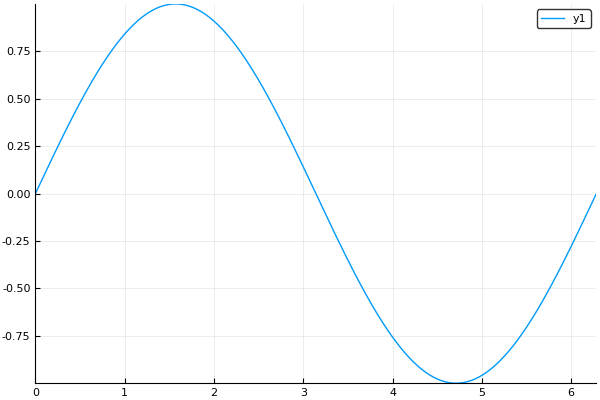

In [29]:
import Plots
Plots.plot(0:0.01:2π,sin)

# The Bad
- As the Julia version is < 1.0, the language syntax + structure is in flux from version to version. The next version (0.7) is slated for release soon*, which is going to be reversioned to 1.0 and at that point the language specification will be fixed. 
   - The Julia folks try to preserve backwards compatibility, but this isn't always possible (*)
- Okay IDE integration 
   - sophisticated tools developed for Atom, but Atom itself is pretty terrible
   - emacs, vim, visual studio code
- You actually have to care about types in order to get performance out of your code (could be a bad thing if you're used to Python's type-free environment)

# The Ugly
- Because of (*), the previous debugger was written for Julia 0.5. For 0.6, the current version, there's no debugger :( 
   - Hopefully will be fixed for 0.7/1.0, but I haven't heard anything on that end

# Fun Links
1. "How Python was Shaped by leaky Internals" https://www.youtube.com/watch?v=qCGofLIzX6g
2. "Why Julia" http://ucidatascienceinitiative.github.io/IntroToJulia/Html/WhyJulia
3. Julia manual https://docs.julialang.org/en/latest/
4. Loop fusion in Julia https://julialang.org/blog/2017/01/moredots

# Useful Packages
1. Revise.jl - Automatic type/function reloading upon source changes, very useful for development - https://github.com/timholy/Revise.jl 
2. Machine Learning Packages
   - Flux - https://fluxml.github.io/Flux.jl/stable/
   - TensorFlow - https://github.com/malmaud/TensorFlow.jl
   - ForwardDiff - automatic differentiation - https://github.com/JuliaDiff/ForwardDiff.jl   
3. Statistical Computing - https://github.com/JuliaStats
   - Generalized Linear Models - https://github.com/JuliaStats/GLM.jl
   - Time Series - https://github.com/JuliaStats/TimeSeries.jl
   - ScikitLearn - https://github.com/cstjean/ScikitLearn.jl   
4. Optimization - http://www.juliaopt.org/packages/
5. Miscellaneous
   - JOLI - Linear operator wrappers - https://github.com/slimgroup/JOLI.jl
   - DifferentialEquations - high performance + versatile differential equations solver - https://github.com/JuliaDiffEq/DifferentialEquations.jl
   - DualNumbers - https://github.com/JuliaDiff/DualNumbers.jl
   - List of Earth Science packages - https://github.com/svaksha/Julia.jl/blob/master/Earth-Science.md